/var/folders/br/kq87tyss28s11srrpsbpqhhr0000gn/T/ipykernel_15869/435208619.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Annee'] = df['Annee'].fillna(method='ffill')


Modèle chargé depuis sarima_model.joblib
Erreur absolue moyenne (MAE) : 13.44
Précision moyenne : 89.19%
Modèle mis à jour et resauvegardé.


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_pred

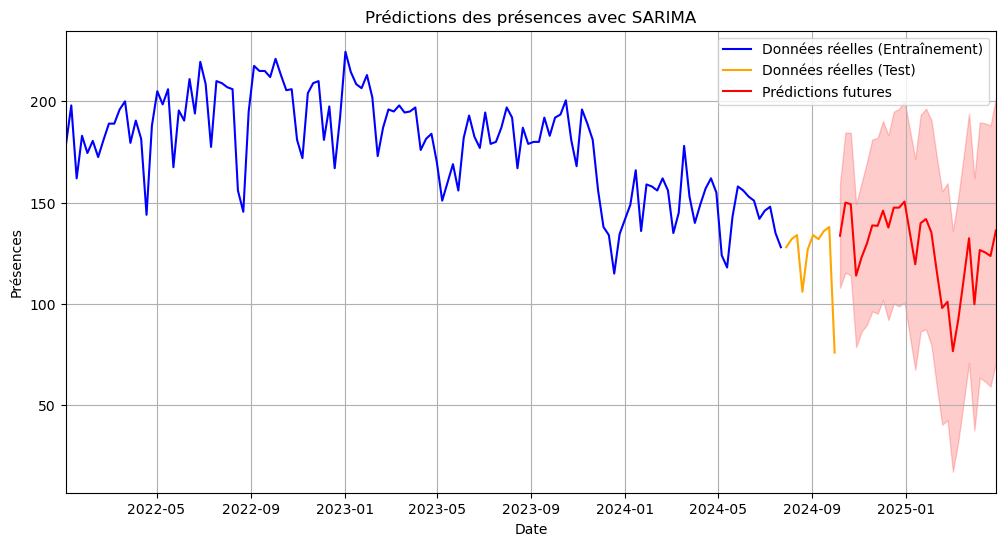

Prédictions pour les 30 prochaines semaines :
2024-10-07 : 133.69 présences
2024-10-14 : 150.01 présences
2024-10-21 : 149.28 présences
2024-10-28 : 113.97 présences
2024-11-04 : 122.91 présences
2024-11-11 : 129.78 présences
2024-11-18 : 138.77 présences
2024-11-25 : 138.57 présences
2024-12-02 : 146.07 présences
2024-12-09 : 137.69 présences
2024-12-16 : 147.54 présences
2024-12-23 : 147.55 présences
2024-12-30 : 150.55 présences
2025-01-06 : 134.99 présences
2025-01-13 : 119.58 présences
2025-01-20 : 139.89 présences
2025-01-27 : 141.91 présences
2025-02-03 : 135.28 présences
2025-02-10 : 116.06 présences
2025-02-17 : 98.00 présences
2025-02-24 : 101.09 présences
2025-03-03 : 76.70 présences
2025-03-10 : 92.30 présences
2025-03-17 : 112.02 présences
2025-03-24 : 132.43 présences
2025-03-31 : 99.85 présences
2025-04-07 : 126.63 présences
2025-04-14 : 125.43 présences
2025-04-21 : 123.68 présences
2025-04-28 : 136.24 présences


In [8]:
import joblib
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import Alignment
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Sauvegarde et rechargement du modèle
MODEL_PATH = 'sarima_model.joblib'

# Définir les chemins des fichiers d'entrée et de sortie
input_files = {
    2022: 'PRESENCE_2022.xlsx',
    2023: 'PRESENCE_2023.xlsx',
    2024: 'PRESENCE_2024.xlsx'
}
output_files = {
    2022: 'Total_Presents_2022.xlsx',
    2023: 'Total_Presents_2023.xlsx',
    2024: 'Total_Presents_2024.xlsx'
}
final_output_file = 'Total_Presents_Final.xlsx'

# Fonction pour traiter un fichier donné et générer un fichier avec une colonne "Année"
def process_file(file_path, year, output_path):
    excel_data = pd.ExcelFile(file_path)
    week_sheets = sorted([sheet for sheet in excel_data.sheet_names if sheet.startswith('S')])
    
    results = []
    for sheet in week_sheets:
        data = pd.read_excel(file_path, sheet_name=sheet, header=None)
        row_index = data.apply(lambda row: row.astype(str).str.contains("Total présents", case=False, na=False).any(), axis=1)
        row_indices = row_index[row_index].index.tolist()
        
        if row_indices:
            target_row = data.iloc[row_indices[0]]
            row_sum = pd.to_numeric(target_row, errors='coerce').sum()
            
            # Soustraire 14 pour les années 2022 et 2023
            if year in [2022, 2023]:
                row_sum = max(0, row_sum - 14)  # Assure que le total reste positif
            
            results.append({'Annee': year, 'Semaines': sheet, 'Presences': row_sum})
        else:
            results.append({'Annee': year, 'Semaines': sheet, 'Presences': 0})
    
    results_df = pd.DataFrame(results)
    results_df.to_excel(output_path, index=False)

# Traiter chaque fichier (2022, 2023, 2024)
for year, input_file in input_files.items():
    process_file(input_file, year, output_files[year])

# Fusionner les fichiers en un seul fichier final
final_results = []
for year, output_file in output_files.items():
    year_df = pd.read_excel(output_file)
    final_results.append(year_df)

# Consolider toutes les données en une seule DataFrame
final_df = pd.concat(final_results, ignore_index=True)
final_df.to_excel(final_output_file, index=False)

# Charger les données consolidées
df = pd.read_excel(final_output_file)
df['Annee'] = df['Annee'].fillna(method='ffill')
df = df.dropna(subset=['Semaines', 'Presences'])
df['Semaines'] = df['Semaines'].str.extract(r'(\d+)').astype(int)

# Convertir Année et Semaines en Date
def year_week_to_date(year, week):
    first_day = datetime(year, 1, 1)
    first_week_start = first_day + timedelta(days=(7 - first_day.weekday()))  # Premier lundi
    return first_week_start + timedelta(weeks=week - 1)

df['Date'] = df.apply(lambda row: year_week_to_date(int(row['Annee']), int(row['Semaines'])), axis=1)
df.set_index('Date', inplace=True)
time_series = df['Presences']

# Diviser en train/test
train = time_series[:-10]
test = time_series[-10:]

# Vérifier si le modèle est déjà sauvegardé
try:
    sarima_model = joblib.load(MODEL_PATH)
    print("Modèle chargé depuis", MODEL_PATH)
except FileNotFoundError:
    # Si le modèle n'existe pas, l'entraîner et le sauvegarder
    p, d, q = 2, 1, 2
    P, D, Q, s = 1, 1, 1, 52
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
    sarima_model = model.fit(disp=False)
    joblib.dump(sarima_model, MODEL_PATH)
    print("Modèle entraîné et sauvegardé dans", MODEL_PATH)

# Prédictions et mise à jour du modèle
forecast = sarima_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
mae = mean_absolute_error(test, forecast_mean)
mae_percentage = (mae / test.mean()) * 100 
print(f"Erreur absolue moyenne (MAE) : {mae:.2f}")
print(f"Précision moyenne : {100 - mae_percentage:.2f}%")

# Sauvegarder les modifications dans le modèle
joblib.dump(sarima_model, MODEL_PATH)
print("Modèle mis à jour et resauvegardé.")

# Prédictions futures
future_forecast = sarima_model.get_forecast(steps=30)
future_index = pd.date_range(start=time_series.index[-1] + timedelta(weeks=1), periods=30, freq='W-MON')
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

# Affichage des prédictions et des intervalles de confiance
plt.figure(figsize=(12, 6))
plt.plot(train, label='Données réelles (Entraînement)', color='blue')
plt.plot(test, label='Données réelles (Test)', color='orange')
plt.fill_between(forecast_mean.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.plot(future_index, future_mean, label='Prédictions futures', color='red')
plt.fill_between(future_index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], color='red', alpha=0.2)
plt.xlim(train.index.min(), future_index.max())
plt.title("Prédictions des présences avec SARIMA")
plt.xlabel("Date")
plt.ylabel("Présences")
plt.legend()
plt.grid()
plt.show()

# Affichage des prédictions futures
print("Prédictions pour les 30 prochaines semaines :")
for date, pred in zip(future_index, future_mean):
    print(f"{date.strftime('%Y-%m-%d')} : {pred:.2f} présences")


In [10]:
pip install sklearn

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g